In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
SAVE = '/content/gdrive/My Drive/covid_clf/'

In [ ]:
!pip install -r colab_requirements.txt
!pip install torch==1.5.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# It may be required to restart the runtime after executing this cell

  Using cached https://files.pythonhosted.org/packages/27/3c/91ed8f5c4e7ef3227b4119200fc0ed4b4fd965b1f0172021c25701087825/transformers-3.0.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/40/d0/30d5f8d221a0ed981a186c8eb986ce1c94e3a6e87f994eae9f4aa5250217/tokenizers-0.8.1rc1-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: tokenizers 0.5.2
    Uninstalling tokenizers-0.5.2:
      Successfully uninstalled tokenizers-0.5.2
  Found existing installation: transformers 2.8.0
    Uninstalling transformers-2.8.0:
      Successfully uninstalled transformers-2.8.0
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
import os
import re
import csv
import math
import time
import random

import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import AutoModel, AutoTokenizer
from transformers import modeling_bert

%matplotlib inline

In [ ]:
if torch.cuda.is_available():
  print(torch.cuda.get_device_name())
else:
  print("Using CPU, change runtime type to speed up fine-tuning")

Tesla V100-SXM2-16GB


Data Import and EDA

In [ ]:
data = pd.read_csv('./expanded_annotations.csv', header=0)
print(data.shape)
data.head()

(6492, 5)


,PREDICATE,SUBJECT_TEXT,OBJECT_TEXT,SENTENCE,LABEL
0,ADMINISTERED_TO,MTX,patients,"At 2 years of followup, 60 patients (48%) cont...",1
1,COEXISTS_WITH,foreign bodies,brain abscess,The diagnostic significance of change in posit...,1
2,USES,micropipet,glass,Unilateral microinjection of bombesin or vehic...,0
3,COEXISTS_WITH,monoclonal antibody,liposomes,A monoclonal antibody was produced that ...,1
4,TREATS,Infusion,rat,Infusion of prostacyclin (PGI2) reportedly att...,0


In [ ]:
pd.crosstab(data.PREDICATE, data.LABEL)

LABEL,0,1
PREDICATE,,
ADMINISTERED_TO,18,175
AFFECTS,29,53
ASSOCIATED_WITH,12,70
AUGMENTS,29,53
CAUSES,15,67
COEXISTS_WITH,68,256
COMPLICATES,3,101
DIAGNOSES,39,152
DISRUPTS,31,51


(4280, 5)


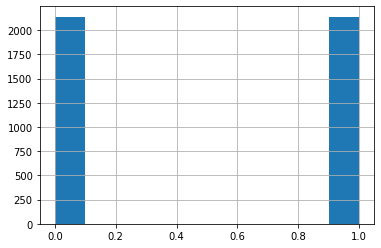

In [ ]:
sub_data = data[data.LABEL == 0]
sub_data = pd.concat([sub_data, data[data.LABEL == 1].sample(n=len(sub_data), replace=False)])
print(sub_data.shape)
sub_data.LABEL.hist()

In [ ]:
predicates = ['COEXISTS_WITH', 'COMPLICATES','MANIFESTATION_OF',
              'PREVENTS', 'PRODUCES', 'TREATS', 
              'INTERACTS_WITH', 'STIMULATES', 
              'INHIBITS', 'CAUSES', 'PREDISPOSES', 
              'ASSOCIATED_WITH', 'DISRUPTS', 'AUGMENTS', 
              'AFFECTS']

In [ ]:
data = data[data.PREDICATE.isin(predicates)]
print(len(data))
print(data.LABEL.mean())
data.head()

4858
0.6058048579662413


,PREDICATE,SUBJECT_TEXT,OBJECT_TEXT,SENTENCE,LABEL
1,COEXISTS_WITH,foreign bodies,brain abscess,The diagnostic significance of change in posit...,1
3,COEXISTS_WITH,monoclonal antibody,liposomes,A monoclonal antibody was produced that ...,1
4,TREATS,Infusion,rat,Infusion of prostacyclin (PGI2) reportedly att...,0
5,TREATS,therapy,cancer,[Symptomatic butalidone therapy in cancer].,1
6,TREATS,chemotherapy,patients,Three patients relapsed after primary irradiat...,1


In [ ]:
ctab = pd.crosstab(data.PREDICATE, data.LABEL)
print(len(ctab))
ctab

15


LABEL,0,1
PREDICATE,,
AFFECTS,29,53
ASSOCIATED_WITH,12,70
AUGMENTS,29,53
CAUSES,15,67
COEXISTS_WITH,68,256
COMPLICATES,3,101
DISRUPTS,31,51
INHIBITS,281,323
INTERACTS_WITH,756,1025


Mean:  0.6058048579662413


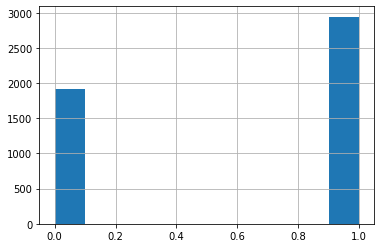

In [ ]:
data.LABEL.hist()
print("Mean: ", data.LABEL.mean())

(3830, 5)


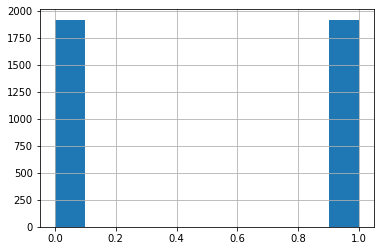

In [ ]:
sub_data = data[data.LABEL == 0]
sub_data = pd.concat([sub_data, data[data.LABEL == 1].sample(n=len(sub_data), replace=False)])
print(sub_data.shape)
sub_data.LABEL.hist()

Data Preprocessing

In [ ]:
def standardize_text(string):
  """
  Removes non-alphanumeric characters except hyphens
  Removes extra whitespaces
  """
  pattern = re.compile('[\W_]+')
  temp = pattern.sub(' ', string)
  temp = ' '.join(temp.split())
  temp = temp.lower()

  return temp

In [ ]:
def make_tuple(string):
  toks = string.split('&')
  for i, tok in enumerate(toks):
    t = tok.split()
    t = ' '.join(t)
    toks[i] = t
  return tuple(toks)

sub_data['TRIPLE'] = (sub_data.SUBJECT_TEXT + '&' + sub_data.PREDICATE + '&' +sub_data.OBJECT_TEXT).apply(make_tuple)

sub_data['TRIPLE'].head(20)

4                                (Infusion, TREATS, rat)
7      (hydroxylase, COEXISTS_WITH, vitamin D3 metabo...
11                 (dehydroepiandrosterone, TREATS, men)
17     (apolipoproteins, COEXISTS_WITH, apolipoprotei...
22                                (DDS, TREATS, leprosy)
37                (Discharge planning, TREATS, children)
40                         (therapy, PREVENTS, toxicity)
42                (surgical procedures, TREATS, disease)
47                        (HeLa cells, PRODUCES, genome)
48     (skeletal pin fixation, PREVENTS, mandibular f...
51            (Gallium nitrate, PREVENTS, hypercalcemia)
54     (peripheral neurofibromatosis, COEXISTS_WITH, ...
56                          (abortion, TREATS, patients)
59                          (antiserum, TREATS, rabbits)
66                            (oestrogens, TREATS, boar)
69     (psychological, MANIFESTATION_OF, cognitive de...
80             (vaccination, TREATS, multiple sclerosis)
90                        (VACC

In [ ]:
# Start with sentences and triples to be used for training
X = sub_data[['TRIPLE', 'SENTENCE']]
y = sub_data['LABEL'].values

In [ ]:
def joining(text, triple):
  sub, pred, obj = triple
  text = ' '.join(text.split()) # Clears extra spaces
  text += f" [SEP] {sub} {pred} {obj}"
  return text

def triple_joining(triple):
  sub, pred, obj = triple
  return ' '.join([sub, pred, obj])

In [ ]:
X = np.vectorize(joining)(X.SENTENCE, X.TRIPLE)

In [ ]:
X[0]

'Infusion of prostacyclin (PGI2) reportedly attenuates renal ischemic injury in the dog and the rat. [SEP] Infusion TREATS rat'

**Modeling**

In [ ]:
class PubMedBERT(nn.Module):
  """
  The PubMed implementation does not include a classification head
  so one must be added. The classification head is added in the same manner
  as the other HuggingFace BERT models for consistency.
  """
  def __init__(self):
    super().__init__()
    self.weight_path = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
    self.bert = AutoModel.from_pretrained(self.weight_path)
    self.drop = nn.Dropout(0.1, False)
    self.fc_out = nn.Linear(768, 2, True)

  def forward(self, input_ids, token_type_ids, attention_masks,
              return_dict=None):
    outputs = self.bert(input_ids, 
                             attention_mask=attention_masks,
                             token_type_ids=token_type_ids
                             )
    pooled_output = outputs[1]
    pooled_output = self.drop(pooled_output)
    logits = self.fc_out(pooled_output)

    loss = None
    if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

    return modeling_bert.SequenceClassifierOutput(loss=loss, logits=logits,
                                    hidden_states=outputs.hidden_states, 
                                    attentions=outputs.attentions)


class BioClinicalBERT(nn.Module):
  """
  The Bio Clinical BERT implementation does not include a classification head
  so one must be added. The classification head is added in the same manner
  as the other HuggingFace BERT models for consistency.
  """
  def __init__(self):
    super().__init__()
    self.weight_path = "emilyalsentzer/Bio_ClinicalBERT"
    self.bert = AutoModel.from_pretrained(self.weight_path)
    self.drop = nn.Dropout(0.1, False)
    self.fc_out = nn.Linear(768, 2, True)

  def forward(self, input_ids, token_type_ids, attention_masks,
              return_dict=None):
    outputs = self.bert(input_ids, 
                             attention_mask=attention_masks,
                             token_type_ids=token_type_ids
                             )
    pooled_output = outputs[1]
    pooled_output = self.drop(pooled_output)
    logits = self.fc_out(pooled_output)

    loss = None
    if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

    return modeling_bert.SequenceClassifierOutput(loss=loss, logits=logits,
                                    hidden_states=outputs.hidden_states, 
                                    attentions=outputs.attentions)


class BioBERT(nn.Module):
  """
  The Bio BERT implementation does not include a classification head
  so one must be added. The classification head is added in the same manner
  as the other HuggingFace BERT models for consistency.
  """
  def __init__(self):
    super().__init__()
    self.weight_path = "./biobert_v1.1_pubmed/"
    self.bert = AutoModel.from_pretrained(self.weight_path, force_download=True)
    self.drop = nn.Dropout(0.1, False)
    self.fc_out = nn.Linear(768, 2, True)
    
  def forward(self, input_ids, token_type_ids, attention_masks,
              return_dict=None):
    outputs = self.bert(input_ids, 
                             attention_mask=attention_masks,
                             token_type_ids=token_type_ids
                             )
    pooled_output = outputs[1]
    pooled_output = self.drop(pooled_output)
    logits = self.fc_out(pooled_output)

    loss = None
    if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

    return modeling_bert.SequenceClassifierOutput(loss=loss, logits=logits,
                                    hidden_states=outputs.hidden_states, 
                                    attentions=outputs.attentions)


class BlueBERT(nn.Module):
  """
  The BlueBERT implementation does not include a classification head
  so one must be added. The classification head is added in the same manner
  as the other HuggingFace BERT models for consistency.
  """
  def __init__(self):
    super().__init__()
    self.weight_path = "./ncbi_bert_pubmed_mimic_uncased/"
    self.bert = AutoModel.from_pretrained(self.weight_path, force_download=True)
    self.drop = nn.Dropout(0.1, False)
    self.fc_out = nn.Linear(768, 2, True)

  def forward(self, input_ids, token_type_ids, attention_masks,
              return_dict=None):
    outputs = self.bert(input_ids, 
                             attention_mask=attention_masks,
                             token_type_ids=token_type_ids
                             )
    pooled_output = outputs[1]
    pooled_output = self.drop(pooled_output)
    logits = self.fc_out(pooled_output)

    loss = None
    if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

    return modeling_bert.SequenceClassifierOutput(loss=loss, logits=logits,
                                    hidden_states=outputs.hidden_states, 
                                    attentions=outputs.attentions)


class SemMedDataset(Dataset):
  """
  Dataset class for the several input components
  """
  def __init__(self, input_ids, token_type_ids, attention_masks, labels):
    self.input_ids = input_ids
    self.token_types = token_type_ids
    self.attn_masks = attention_masks
    self.labels = labels

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    return self.input_ids[idx], self.token_types[idx], self.attn_masks[idx], self.labels[idx]

In [ ]:
class Experiment:
  def __init__(self,
               num_trials,
               data,
               labels,
               model_type,
               frozen,
               epochs,
               bsz,
               lr,
               path,
               seeds
              ):
    """
    A single class to manage, execute, and hold the results of each experiment
    """
    assert len(seeds) == num_trials
    self.num_trials = num_trials
    self.data = data
    self.labels = labels
    self.model_type = model_type
    self.frozen = frozen
    self.epochs = epochs
    self.bsz = bsz
    self.lr = lr
    self.seeds = seeds
    self.path = path

    self.experiment_results = {}

    self.device = "cuda" if torch.cuda.is_available() else "cpu"

  def setup_trial(self, seed):
    """
    Seeds the RNGs, instantiates a new model, tokenizer, optimizer, and lr
    scheduler, and splits the data into training and test sets for each trial
    prior to running the trial
    """
    print(f"\tSeed: {seed}")
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    print("\tLoading model...")
    if self.model_type in ['bert-base-uncased', 'bert-base-cased']:
      self.model = transformers.BertForSequenceClassification.from_pretrained(self.model_type)
    elif self.model_type == 'biobert':
      self.model = BioBERT()
    elif self.model_type == 'bluebert':
      self.model = BlueBERT()
    elif self.model_type == 'pubmedbert':
      self.model = PubMedBERT()
    elif self.model_type == 'bioclinicalbert':
      self.model = BioClinicalBERT()
    else:
      raise ValueError('Invalid model_type')
    
    print("\tLoading tokenizer...")
    if self.model_type in ['bert-base-uncased', 'bert-base-cased']:
      self.tokenizer = transformers.BertTokenizer.from_pretrained(self.model_type)
      self.model.resize_token_embeddings(len(self.tokenizer)) # Addition of tokens necessitates resizing
    else:
      self.tokenizer = AutoTokenizer.from_pretrained(self.model.weight_path) 
      self.model.bert.resize_token_embeddings(len(self.tokenizer))
    
    
    print("\tPrepping data...")
    self.train_loader, self.valid_loader, self.test_loader = self.prep_data()
    
    print("\tPreparing optimizer...")
    if self.frozen:
      no_decay = ['bias', 'LayerNorm.weight']
      optimizer_grouped_parameters = [
        {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
      ]
      self.optimizer = transformers.AdamW(optimizer_grouped_parameters, 
                                          lr=self.lr, weight_decay=0.01)
    else:
      self.optimizer = transformers.AdamW(self.model.parameters(),
                                          lr=self.lr, weight_decay=0.01)
    
    print("\tPreparing criterion...")
    self.criterion = nn.CrossEntropyLoss()
    
    print("\tPreparing LR scheduler...")
    self.scheduler = transformers.get_linear_schedule_with_warmup(optimizer=self.optimizer,
                                                             num_warmup_steps=150,
                                                             num_training_steps=self.epochs*len(self.train_loader)
    )
    
  def prep_data(self):
    """
    Handles preprocessing of the input data by tokenizing the sentences/predication
    pairs and splits the data into training and test PyTorch DataLoaders
    for fine-tuning
    """
    encoding = self.tokenizer(self.data.tolist(), 
                              return_tensors='pt', padding=True, truncation=True)
    input_ids_ = encoding['input_ids']
    token_type_ids_ = encoding['token_type_ids']
    attention_mask_ = encoding['attention_mask']

    train_tup, valid_tup, test_tup = self._data_split(input_ids_, 
                                           token_type_ids_,
                                           attention_mask_, 
                                           self.labels,
                                           0.1,
                                           0.1
                                          )
    
    train_dataset = SemMedDataset(*train_tup)
    valid_dataset = SemMedDataset(*valid_tup)
    test_dataset = SemMedDataset(*test_tup)

    train_loader = DataLoader(train_dataset, batch_size=self.bsz, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=1)
    test_loader = DataLoader(test_dataset, batch_size=1)

    return train_loader, valid_loader, test_loader

  def _data_split(self, input_ids, token_type_ids, 
                  attention_masks, labels, valid_prop, test_prop):
    """
    Randomly splits the data into train and test sets. Due to the nature of this
    data and how it needs to be fed to the HuggingFace models, using the standard
    train_test_split from scikit-learn was impractical.
    """
    assert 0 < valid_prop <1
    assert 0 < test_prop < 1
    n_all = len(labels)
    pos_cnt = labels.sum()
    neg_cnt = n_all - pos_cnt

    n_test = int(test_prop * n_all)
    n_test_pos = int(n_test * (pos_cnt / n_all))
    n_test_neg = n_test - n_test_pos

    pos_idx = [idx for idx, label in enumerate(labels) if label == 1]
    neg_idx = [idx for idx, label in enumerate(labels) if label == 0]

    test_pos_sample_idx = torch.tensor(np.random.choice(pos_idx, size=(n_test_pos),
                                                        replace=False),
                                       dtype=torch.long)
    test_neg_sample_idx = torch.tensor(np.random.choice(neg_idx, size=(n_test_neg),
                                                        replace=False),
                                       dtype=torch.long)
    test_sample_idx = torch.cat([test_pos_sample_idx,
                                 test_neg_sample_idx],
                                dim=0)
    
    rem_pos_idx = [idx for idx in pos_idx if idx not in test_pos_sample_idx]
    rem_neg_idx = [idx for idx in neg_idx if idx not in test_neg_sample_idx]

    rem = min(len(rem_pos_idx), len(rem_neg_idx))

    rem_pos_idx = np.random.choice(rem_pos_idx, size=(rem), replace=False)
    rem_neg_idx = np.random.choice(rem_neg_idx, size=(rem), replace=False)

    n_valid = int(rem * valid_prop)
    n_train = rem - n_valid 
    
    train_pos_sample_idx = torch.tensor(np.random.choice(rem_pos_idx, size=(n_train),
                                                         replace=False),
                                        dtype=torch.long)
    train_neg_sample_idx = torch.tensor(np.random.choice(rem_neg_idx, size=(n_train),
                                                         replace=False),
                                        dtype=torch.long)
    train_sample_idx = torch.cat([train_pos_sample_idx,
                                  train_neg_sample_idx],
                                 dim=0)
    
    valid_pos_sample_idx = torch.tensor([idx for idx in rem_pos_idx if idx not in train_pos_sample_idx])
    valid_neg_sample_idx = torch.tensor([idx for idx in rem_neg_idx if idx not in train_neg_sample_idx])
    valid_sample_idx = torch.cat([valid_pos_sample_idx,
                                  valid_neg_sample_idx],
                                 dim=0)

    labels = torch.tensor(labels)

    print("Valid intersect Train")
    print(set(valid_sample_idx.tolist()).intersection(set(train_sample_idx.tolist())))
    print("Valid intersect Test")
    print(set(valid_sample_idx.tolist()).intersection(set(test_sample_idx.tolist())))
    print("Train intersect Test")
    print(set(train_sample_idx.tolist()).intersection(set(test_sample_idx.tolist())))

    # Collect training samples
    # Stratified to be 50/50 split between 0/1 labels
    train_in_ids = input_ids.index_select(0, train_sample_idx)
    train_tt_ids = token_type_ids.index_select(0, train_sample_idx)
    train_am_ids = attention_masks.index_select(0, train_sample_idx)
    train_labels = labels.index_select(0, train_sample_idx)

    train_tuple = (train_in_ids, train_tt_ids, train_am_ids, train_labels)
    
    # Collect validation samples
    # Stratified to be 50/50 split between 0/1 labels
    valid_in_ids = input_ids.index_select(0, valid_sample_idx)
    valid_tt_ids = token_type_ids.index_select(0, valid_sample_idx)
    valid_am_ids = attention_masks.index_select(0, valid_sample_idx)
    valid_labels = labels.index_select(0, valid_sample_idx)

    valid_tuple = (valid_in_ids, valid_tt_ids, valid_am_ids, valid_labels)
    
    # Collect testing samples
    # Stratified to have the same label distribution as the original dataset
    test_in_ids = input_ids.index_select(0, test_sample_idx)
    test_tt_ids = token_type_ids.index_select(0, test_sample_idx)
    test_am_ids = attention_masks.index_select(0, test_sample_idx)
    test_labels = labels.index_select(0, test_sample_idx)

    test_tuple = (test_in_ids, test_tt_ids, test_am_ids, test_labels)

    return train_tuple, valid_tuple, test_tuple

  def run_trial(self, trial_num):
    """
    Executes a single trial from setup through fine_tuning and
    deposits the results into the experiment_results dictionary
    """
    # Fine-tune bert
    print(']==['*20)
    print(f'\tTRIAL {trial_num+1}'*8)
    print('=[]='*20)
    print(f"\tPreparing trial...")
    self.setup_trial(self.seeds[trial_num])
    print("\tRunning trial...")
    train_losses, valid_losses, test_preds, test_labels = self.finetune(trial_num)
    
    results = {'train_losses': train_losses,
               'valid_losses': valid_losses,
               'test_preds': test_preds,
               'test_f1': f1_score(test_labels, test_preds, 
                                   zero_division=0),
               'test_precision': precision_score(test_labels, test_preds, 
                                                 zero_division=0),
               'test_recall': recall_score(test_labels, test_preds, 
                                           zero_division=0)
               }
    
    self.experiment_results.update({f'trial_{trial_num+1}': results})
    print("\tFinished trial!!!")

  def finetune(self, trial_num):
    """
    Typical PyTorch training loop
    """
    all_train_losses = []
    all_valid_losses = []
    best_f1 = 0
    best_loss = np.inf
    early_stopping = 0

    self.model.to(self.device)

    for e in range(1, self.epochs+1):
      if early_stopping >= 3:
        print("Stopping!")
        break

      start_time = time.time()
      print("\t","-"*70)
      print("\t","="*15,f"\tEpoch: {e}\t", "="*15)

      ### TRAINING ###
      self.model.train()
      train_loss = 0
      batch_loss = 0
      for i, (input_id, ttid, attn_mask, label) in enumerate(self.train_loader):
        input_id, ttid = input_id.to(self.device), ttid.to(self.device)
        attn_mask, label = attn_mask.to(self.device), label.to(self.device)
        self.optimizer.zero_grad()
        output = self.model(input_id, ttid, attn_mask)
        loss = self.criterion(output[0], label)
        loss.backward()
        self.optimizer.step()
        self.scheduler.step()

        preds = torch.argmax(F.softmax(output[0], dim=1), dim=1).cpu().detach().numpy()
        labels_ = label.cpu().detach().numpy()

        all_train_losses.append(loss.item())
        train_loss += loss.item()
        batch_loss += loss.item()

        if (i % 50 == 0) and (i > 0):
          print("\t\t\tBatch {:4d} Loss:\t{:.6f}".format(i,batch_loss/50))
          batch_loss = 0

      print("\t\tTraining Results:\n\t\tLoss: {:.6f}".format(train_loss / len(self.train_loader)))
      
      ### EVALUATE ###
      self.model.eval()
      valid_loss = 0
      
      valid_preds, valid_labels = [], []

      for input_id, ttid, attn_mask, label in self.valid_loader:
        input_id, ttid = input_id.to(self.device), ttid.to(self.device)
        attn_mask, label = attn_mask.to(self.device), label.to(self.device)
        output = self.model(input_id, ttid, attn_mask)
        loss = self.criterion(output[0], label)

        valid_preds.append(torch.argmax(F.softmax(output[0], dim=1), dim=1).cpu().detach().item())
        valid_labels.append(label.cpu().detach().item())
        all_valid_losses.append(loss.item())
        valid_loss += loss.item()
      
      valid_f1 = f1_score(valid_labels, valid_preds, zero_division=0)
      valid_recall = recall_score(valid_labels, valid_preds, zero_division=0)
      valid_precision = precision_score(valid_labels, valid_preds, zero_division=0)

      print("\t\tValidation Results:\n\t\tLoss: {:.6f}\tF1: {:.4f}".format(valid_loss / len(self.valid_loader),
                                                                      valid_f1))
      print("\t\t\tRecall: {:.4f}\tPrecision: {:.4f}".format(valid_recall, valid_precision))

      if valid_f1 > best_f1:
        print("New best f1! Saving weights...")
        torch.save(self.model.state_dict(), SAVE+self.path+str(trial_num)+'_'+self.model_type+'.pth')
        print("Saved!")
        print("Evaluating on test set...")
        best_f1 = valid_f1
        best_loss = valid_loss
        early_stopping = 0

        self.model.eval()
        test_loss = 0

        test_preds, test_labels = [], []

        for input_id, ttid, attn_mask, label in self.test_loader:
          input_id, ttid = input_id.to(self.device), ttid.to(self.device)
          attn_mask, label = attn_mask.to(self.device), label.to(self.device)
          output = self.model(input_id, ttid, attn_mask)
          loss = self.criterion(output[0], label)

          test_preds.append(torch.argmax(F.softmax(output[0], dim=1), dim=1).cpu().detach().item())
          test_labels.append(label.cpu().detach().item())
          test_loss += loss.item()

        test_f1 = f1_score(test_labels, test_preds, zero_division=0)
        test_recall = recall_score(test_labels, test_preds, zero_division=0)
        test_precision = precision_score(test_labels, test_preds, zero_division=0)
        print("\t\tTest Results:\n\t\tLoss: {:.6f}\tF1: {:.4f}".format(test_loss / len(self.test_loader),
                                                                      test_f1))
        print("\t\t\tRecall: {:.4f}\tPrecision: {:.4f}".format(test_recall, test_precision))
        best_test_f1 = test_f1

      else:
        early_stopping += 1

    
    ### TEST ###
    self.model.eval()
    test_loss = 0

    test_preds, test_labels = [], []

    for input_id, ttid, attn_mask, label in self.test_loader:
      input_id, ttid = input_id.to(self.device), ttid.to(self.device)
      attn_mask, label = attn_mask.to(self.device), label.to(self.device)
      output = self.model(input_id, ttid, attn_mask)
      loss = self.criterion(output[0], label)

      test_preds.append(torch.argmax(F.softmax(output[0], dim=1), dim=1).cpu().detach().item())
      test_labels.append(label.cpu().detach().item())
      test_loss += loss.item()

    test_f1 = f1_score(test_labels, test_preds, zero_division=0)
    test_recall = recall_score(test_labels, test_preds, zero_division=0)
    test_precision = precision_score(test_labels, test_preds, zero_division=0)
    print("\t\tTest Results:\n\t\tLoss: {:.6f}\tF1: {:.4f}".format(test_loss / len(self.test_loader),
                                                                  test_f1))
    print("\t\t\tRecall: {:.4f}\tPrecision: {:.4f}".format(test_recall, test_precision))

    print("\t\tBest Validation F1: {:.4f}".format(best_f1))
    print("\t\tTest F1 at Best Val: {:.4f}".format(best_test_f1))

    print("\t\tTime elapsed: {:.6f}".format(time.time()-start_time))

    print("\t","-"*70)

    return all_train_losses, all_valid_losses, test_preds, test_labels

  def run_experiments(self):
    """
    Runs all of the trials for the experiment
    """
    for i in range(0, self.num_trials):
      self.run_trial(i)
      self.plot_running_avg(i)
      # self.write_results(i)
      # self.wrong_examples()
      print("\n\n") 

    print("Experiment completed!!")

  def plot_running_avg(self, trial_num, window=25):
    """
    Plots the rolling average for a specified window over
    the train losses from a trial
    """
    trial_num += 1
    losses = np.array(self.experiment_results[f'trial_{trial_num}']['train_losses'])
    N = len(losses)
    running_avg = np.empty(N)
    
    for t in range(N):
        running_avg[t] = losses[max(0, t-window):t+1].mean()
    
    plt.plot(running_avg)
    plt.title(f"Running Average ({window}) Loss")
    plt.show()

  def write_results(self, trial_num):
    """
    Writes trial parameters, train losses, and test losses to text and csv files,
    respectively, for future reference
    """
    trial_num += 1
    results_dir = f'{self.model_type}_{self.frozen}'

    if results_dir not in os.listdir():
      os.makedirs(results_dir)

    results_dir += f'/trial_{trial_num}/'

    os.makedirs(results_dir)

    with open(results_dir+"params.txt", 'w') as f:
      f.write(f"Time: {time.time()}\n")
      f.write(f"Bert Type: {self.model_type}\n")
      f.write(f"Frozen Body: {self.frozen}\n")
      f.write(f"Batch Size: {self.bsz}\n")
      f.write(f"Epochs: {self.epochs}\n")
      f.write(f"Learning Rate: {self.lr}\n")
      f.write(f"Seed: {self.seeds[trial_num-1]}\n")
    f.close()

    with open(results_dir+"train_loss.csv", 'w', newline='') as f:
      wr = csv.writer(f, quoting=csv.QUOTE_ALL)
      wr.writerow(self.experiment_results[f'trial_{trial_num}']['train_losses'])
    f.close()

    with open(results_dir+"valid_loss.csv", 'w', newline='') as f:
      wr = csv.writer(f, quoting=csv.QUOTE_ALL)
      wr.writerow(self.experiment_results[f'trial_{trial_num}']['test_losses'])
    f.close()

    print("Data saved!")

In [ ]:
NUM_TRIALS = 10
SEEDS = np.random.randint(0, 10000, size=(NUM_TRIALS))
print(SEEDS)

[3292 6822 2622  680 5445 1978 7617 7281 1728 1386]


In [ ]:
# Fixed hyperparameters
EPOCHS = 7
LR = 1e-5
BSZ = 16 # small due to memory restrictions

In [ ]:
bert_uncased = Experiment(num_trials=NUM_TRIALS,
                      data=X,
                      labels=y,
                      model_type='bert-base-uncased',
                      frozen=False,
                      epochs=EPOCHS,
                      bsz=BSZ,
                      lr=LR,
                      path='bert_uncased',
                      seeds=SEEDS
                      )

]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 3292
	Loading model...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

	Loading tokenizer...
	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.709291
			Batch  100 Loss:	0.689348
			Batch  150 Loss:	0.679503
		Training Results:
		Loss: 0.688209
		Validation Results:
		Loss: 0.678548	F1: 0.4659
			Recall: 0.3779	Precision: 0.6075
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.666862	F1: 0.5758
			Recall: 0.4974	Precision: 0.6835
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.694155
			Batch  100 Loss:	0.681090
			Batch  150 Loss:	0.654890
		Training Results:
		Loss: 0.672122
		Validation Results:
		Loss: 0.684857	F1: 0.5285
			Recall: 0.5116	Pre

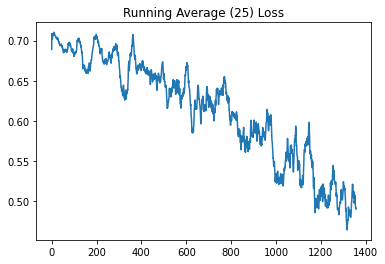




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 6822
	Loading model...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

	Loading tokenizer...
	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.720911
			Batch  100 Loss:	0.700061
			Batch  150 Loss:	0.677821
		Training Results:
		Loss: 0.690303
		Validation Results:
		Loss: 0.687620	F1: 0.2817
			Recall: 0.1744	Precision: 0.7317
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.688192	F1: 0.2026
			Recall: 0.1204	Precision: 0.6389
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.667025
			Batch  100 Loss:	0.656491
			Batch  150 Loss:	0.631554
		Training Results:
		Loss: 0.649901
		Validation Results:
		Loss: 0.660614	F1: 0.6700
			Recall: 0.7733	Pre

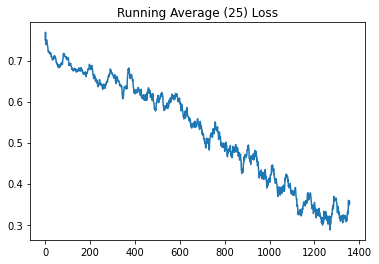




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 2622
	Loading model...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

	Loading tokenizer...
	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.723356
			Batch  100 Loss:	0.687806
			Batch  150 Loss:	0.665459
		Training Results:
		Loss: 0.683388
		Validation Results:
		Loss: 0.671852	F1: 0.5741
			Recall: 0.5407	Precision: 0.6118
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.667116	F1: 0.5815
			Recall: 0.5602	Precision: 0.6045
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.684153
			Batch  100 Loss:	0.665181
			Batch  150 Loss:	0.648363
		Training Results:
		Loss: 0.655905
		Validation Results:
		Loss: 0.675383	F1: 0.5545
			Recall: 0.4884	Pre

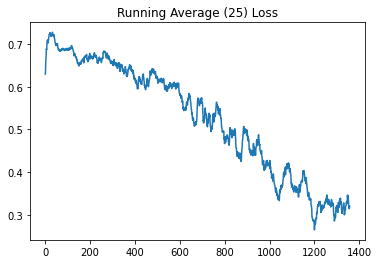




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 680
	Loading model...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

	Loading tokenizer...
	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.698561
			Batch  100 Loss:	0.707487
			Batch  150 Loss:	0.689956
		Training Results:
		Loss: 0.693580
		Validation Results:
		Loss: 0.689617	F1: 0.4138
			Recall: 0.3140	Precision: 0.6067
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.688718	F1: 0.4491
			Recall: 0.3351	Precision: 0.6809
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.701640
			Batch  100 Loss:	0.686967
			Batch  150 Loss:	0.674875
		Training Results:
		Loss: 0.681256
		Validation Results:
		Loss: 0.662204	F1: 0.6683
			Recall: 0.8081	Pre

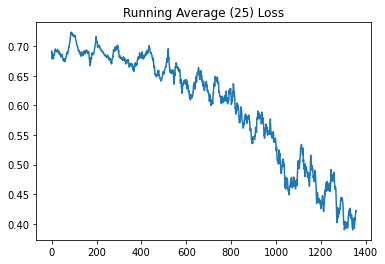




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 5445
	Loading model...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

	Loading tokenizer...
	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.703547
			Batch  100 Loss:	0.677156
			Batch  150 Loss:	0.686090
		Training Results:
		Loss: 0.681901
		Validation Results:
		Loss: 0.674178	F1: 0.4115
			Recall: 0.2907	Precision: 0.7042
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.664818	F1: 0.4135
			Recall: 0.2880	Precision: 0.7333
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.660729
			Batch  100 Loss:	0.659800
			Batch  150 Loss:	0.671596
		Training Results:
		Loss: 0.665143
		Validation Results:
		Loss: 0.706400	F1: 0.6693
			Recall: 0.9826	Pre

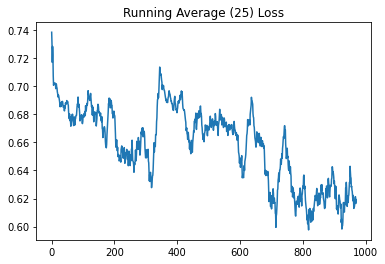




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 1978
	Loading model...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

	Loading tokenizer...
	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.689007
			Batch  100 Loss:	0.667982
			Batch  150 Loss:	0.695091
		Training Results:
		Loss: 0.680047
		Validation Results:
		Loss: 0.679453	F1: 0.4190
			Recall: 0.3081	Precision: 0.6543
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.682629	F1: 0.4203
			Recall: 0.3037	Precision: 0.6824
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.673373
			Batch  100 Loss:	0.672928
			Batch  150 Loss:	0.656092
		Training Results:
		Loss: 0.659198
		Validation Results:
		Loss: 0.645734	F1: 0.6045
			Recall: 0.5465	Pre

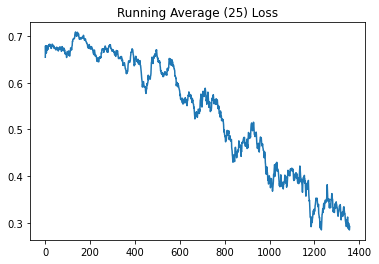




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 7617
	Loading model...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

	Loading tokenizer...
	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.699338
			Batch  100 Loss:	0.672639
			Batch  150 Loss:	0.671341
		Training Results:
		Loss: 0.680550
		Validation Results:
		Loss: 0.650352	F1: 0.6490
			Recall: 0.6395	Precision: 0.6587
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.665030	F1: 0.5984
			Recall: 0.5812	Precision: 0.6167
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.684584
			Batch  100 Loss:	0.643935
			Batch  150 Loss:	0.653587
		Training Results:
		Loss: 0.659585
		Validation Results:
		Loss: 0.638419	F1: 0.6959
			Recall: 0.7849	Pre

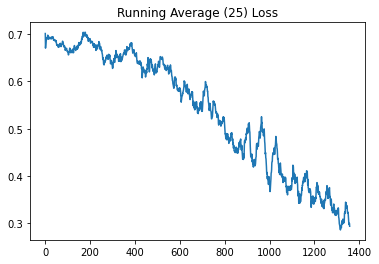




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 7281
	Loading model...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

	Loading tokenizer...
	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.703125
			Batch  100 Loss:	0.680700
			Batch  150 Loss:	0.686672
		Training Results:
		Loss: 0.679281
		Validation Results:
		Loss: 0.652979	F1: 0.6683
			Recall: 0.7849	Precision: 0.5819
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.660541	F1: 0.6623
			Recall: 0.7958	Precision: 0.5672
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.647522
			Batch  100 Loss:	0.660392
			Batch  150 Loss:	0.647724
		Training Results:
		Loss: 0.648166
		Validation Results:
		Loss: 0.621872	F1: 0.6250
			Recall: 0.5523	Pre

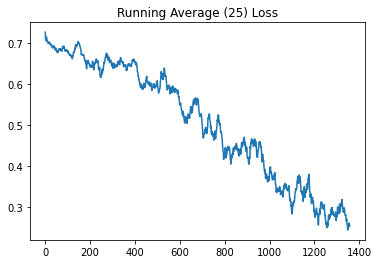




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 1728
	Loading model...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

	Loading tokenizer...
	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.706354
			Batch  100 Loss:	0.695823
			Batch  150 Loss:	0.677516
		Training Results:
		Loss: 0.684733
		Validation Results:
		Loss: 0.659954	F1: 0.6785
			Recall: 0.7791	Precision: 0.6009
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.661938	F1: 0.6711
			Recall: 0.7958	Precision: 0.5802
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.678695
			Batch  100 Loss:	0.665071
			Batch  150 Loss:	0.652838
		Training Results:
		Loss: 0.664521
		Validation Results:
		Loss: 0.684193	F1: 0.5686
			Recall: 0.5058	Pre

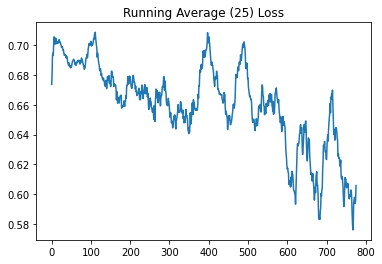




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 1386
	Loading model...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

	Loading tokenizer...
	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.721798
			Batch  100 Loss:	0.690330
			Batch  150 Loss:	0.687111
		Training Results:
		Loss: 0.694578
		Validation Results:
		Loss: 0.672196	F1: 0.6598
			Recall: 0.7442	Precision: 0.5926
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.672000	F1: 0.6588
			Recall: 0.7277	Precision: 0.6017
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.705937
			Batch  100 Loss:	0.680023
			Batch  150 Loss:	0.674770
		Training Results:
		Loss: 0.673621
		Validation Results:
		Loss: 0.649474	F1: 0.6612
			Recall: 0.6977	Pre

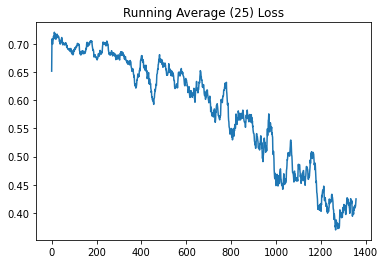




Experiment completed!!


In [ ]:
bert_uncased.run_experiments()

In [ ]:
bert_cased = Experiment(num_trials=NUM_TRIALS,
                      data=X,
                      labels=y,
                      model_type='bert-base-cased',
                      frozen=False,
                      epochs=EPOCHS,
                      bsz=BSZ,
                      lr=LR,
                      path='bert_cased',
                      seeds=SEEDS
                      )

]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 3292
	Loading model...


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

	Loading tokenizer...
	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.704806
			Batch  100 Loss:	0.676988
			Batch  150 Loss:	0.687238
		Training Results:
		Loss: 0.690891
		Validation Results:
		Loss: 0.686372	F1: 0.6667
			Recall: 0.8953	Precision: 0.5310
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.686125	F1: 0.6615
			Recall: 0.8901	Precision: 0.5263
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.701937
			Batch  100 Loss:	0.671985
			Batch  150 Loss:	0.664923
		Training Results:
		Loss: 0.673093
		Validation Results:
		Loss: 0.659028	F1: 0.5904
			Recall: 0.5698	Pre

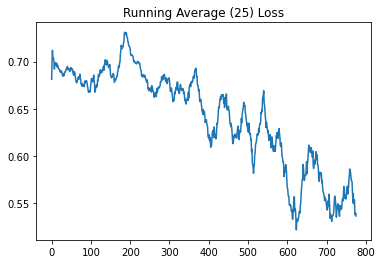




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 6822
	Loading model...


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

	Loading tokenizer...
	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.723671
			Batch  100 Loss:	0.689090
			Batch  150 Loss:	0.661206
		Training Results:
		Loss: 0.691865
		Validation Results:
		Loss: 0.695154	F1: 0.0000
			Recall: 0.0000	Precision: 0.0000
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.706013
			Batch  100 Loss:	0.683597
			Batch  150 Loss:	0.676863
		Training Results:
		Loss: 0.681919
		Validation Results:
		Loss: 0.691247	F1: 0.3319
			Recall: 0.2267	Precision: 0.6190
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.701175	F1: 0.2972
			Recall: 0.1937	Pre

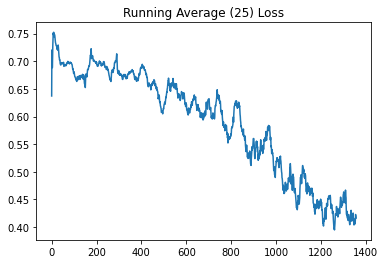




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 2622
	Loading model...


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

	Loading tokenizer...
	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.714320
			Batch  100 Loss:	0.682350
			Batch  150 Loss:	0.675246
		Training Results:
		Loss: 0.683247
		Validation Results:
		Loss: 0.665932	F1: 0.5545
			Recall: 0.4884	Precision: 0.6412
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.666208	F1: 0.5552
			Recall: 0.4869	Precision: 0.6458
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.651401
			Batch  100 Loss:	0.624293
			Batch  150 Loss:	0.643252
		Training Results:
		Loss: 0.634015
		Validation Results:
		Loss: 0.656327	F1: 0.6372
			Recall: 0.6279	Pre

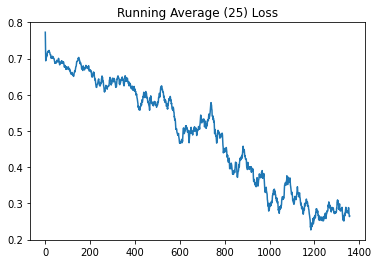




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 680
	Loading model...


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

	Loading tokenizer...
	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.715702
			Batch  100 Loss:	0.688644
			Batch  150 Loss:	0.667973
		Training Results:
		Loss: 0.682374
		Validation Results:
		Loss: 0.665554	F1: 0.6885
			Recall: 0.8547	Precision: 0.5765
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.652608	F1: 0.6925
			Recall: 0.8901	Precision: 0.5667
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.673611
			Batch  100 Loss:	0.638100
			Batch  150 Loss:	0.632693
		Training Results:
		Loss: 0.641322
		Validation Results:
		Loss: 0.628833	F1: 0.6355
			Recall: 0.5930	Pre

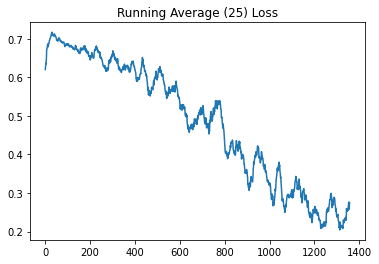




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 5445
	Loading model...


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

	Loading tokenizer...
	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.709367
			Batch  100 Loss:	0.676466
			Batch  150 Loss:	0.692082
		Training Results:
		Loss: 0.682306
		Validation Results:
		Loss: 0.676285	F1: 0.6447
			Recall: 0.7384	Precision: 0.5721
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.661360	F1: 0.6682
			Recall: 0.7749	Precision: 0.5873
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.699065
			Batch  100 Loss:	0.673649
			Batch  150 Loss:	0.667946
		Training Results:
		Loss: 0.666550
		Validation Results:
		Loss: 0.652601	F1: 0.6209
			Recall: 0.6047	Pre

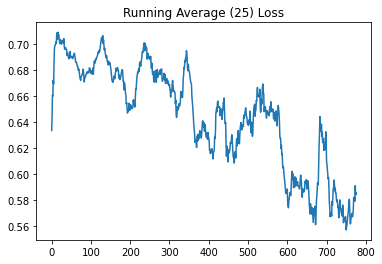




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 1978
	Loading model...


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

	Loading tokenizer...
	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.721631
			Batch  100 Loss:	0.694566
			Batch  150 Loss:	0.670725
		Training Results:
		Loss: 0.688194
		Validation Results:
		Loss: 0.658790	F1: 0.5230
			Recall: 0.4302	Precision: 0.6667
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.660034	F1: 0.5034
			Recall: 0.3927	Precision: 0.7009
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.675280
			Batch  100 Loss:	0.654530
			Batch  150 Loss:	0.637446
		Training Results:
		Loss: 0.648924
		Validation Results:
		Loss: 0.628840	F1: 0.6139
			Recall: 0.5407	Pre

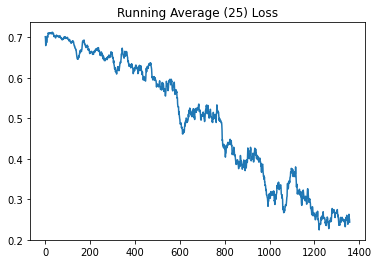




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 7617
	Loading model...


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

	Loading tokenizer...
	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.708029
			Batch  100 Loss:	0.691206
			Batch  150 Loss:	0.676348
		Training Results:
		Loss: 0.680492
		Validation Results:
		Loss: 0.697188	F1: 0.6721
			Recall: 0.9593	Precision: 0.5172
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.694336	F1: 0.6926
			Recall: 0.9791	Precision: 0.5358
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.682102
			Batch  100 Loss:	0.642889
			Batch  150 Loss:	0.612314
		Training Results:
		Loss: 0.643120
		Validation Results:
		Loss: 0.652906	F1: 0.6831
			Recall: 0.8837	Pre

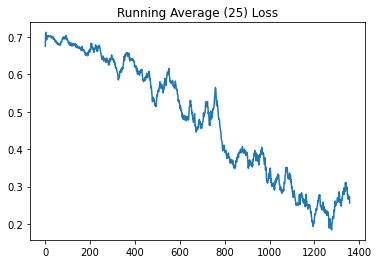




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 7281
	Loading model...


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

	Loading tokenizer...
	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.707700
			Batch  100 Loss:	0.681058
			Batch  150 Loss:	0.670560
		Training Results:
		Loss: 0.684399
		Validation Results:
		Loss: 0.682786	F1: 0.6621
			Recall: 0.8372	Precision: 0.5475
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.681761	F1: 0.6639
			Recall: 0.8482	Precision: 0.5455
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.693071
			Batch  100 Loss:	0.673068
			Batch  150 Loss:	0.676213
		Training Results:
		Loss: 0.675918
		Validation Results:
		Loss: 0.683790	F1: 0.6507
			Recall: 0.7907	Pre

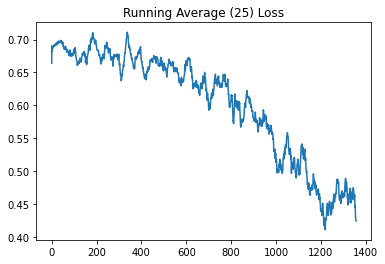




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 1728
	Loading model...


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

	Loading tokenizer...
	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.708374
			Batch  100 Loss:	0.690996
			Batch  150 Loss:	0.670122
		Training Results:
		Loss: 0.682305
		Validation Results:
		Loss: 0.634029	F1: 0.6751
			Recall: 0.7733	Precision: 0.5991
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.661797	F1: 0.6536
			Recall: 0.7853	Precision: 0.5597
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.669606
			Batch  100 Loss:	0.616591
			Batch  150 Loss:	0.615452
		Training Results:
		Loss: 0.630269
		Validation Results:
		Loss: 0.582473	F1: 0.6795
			Recall: 0.6163	Pre

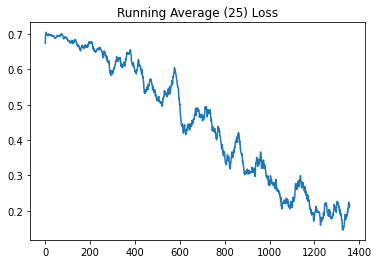




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 1386
	Loading model...


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

	Loading tokenizer...
	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.720122
			Batch  100 Loss:	0.683922
			Batch  150 Loss:	0.673947
		Training Results:
		Loss: 0.683106
		Validation Results:
		Loss: 0.646165	F1: 0.5852
			Recall: 0.5291	Precision: 0.6547
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.636688	F1: 0.5970
			Recall: 0.5236	Precision: 0.6944
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.654466
			Batch  100 Loss:	0.635187
			Batch  150 Loss:	0.635294
		Training Results:
		Loss: 0.637260
		Validation Results:
		Loss: 0.636286	F1: 0.6630
			Recall: 0.7093	Pre

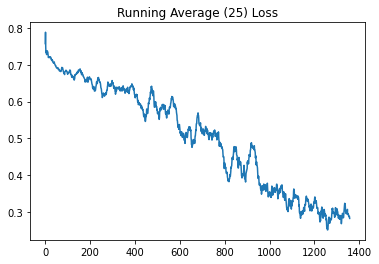




Experiment completed!!


In [ ]:
bert_cased.run_experiments()

In [ ]:
biobert = Experiment(num_trials=NUM_TRIALS,
                      data=X,
                      labels=y,
                      model_type='biobert',
                      frozen=False,
                      epochs=EPOCHS,
                      bsz=BSZ,
                      lr=LR,
                      path='biobert',
                      seeds=SEEDS
)

"biobert = Experiment(num_trials=NUM_TRIALS,\n                      data=X,\n                      labels=y,\n                      model_type='biobert',\n                      frozen=False,\n                      epochs=EPOCHS,\n                      bsz=BSZ,\n                      lr=LR,\n                      path='biobert',\n                      seeds=SEEDS\n                      )"

In [ ]:
biobert.run_experiments()

In [ ]:
bioclinbert = Experiment(num_trials=NUM_TRIALS,
                      data=X,
                      labels=y,
                      model_type='bioclinicalbert',
                      frozen=False,
                      epochs=EPOCHS,
                      bsz=BSZ,
                      lr=LR,
                      path='bioclinicalbert',
                      seeds=SEEDS
                      )

]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 3292
	Loading model...
	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.730760
			Batch  100 Loss:	0.697290
			Batch  150 Loss:	0.668649
		Training Results:
		Loss: 0.686514
		Validation Results:
		Loss: 0.649649	F1: 0.6450
			Recall: 0.6919	Precision: 0.6041
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.624375	F1: 0.6800
			Recall: 0.7120	Precision: 0.6507
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.650319
			Batch  100 Loss:	0.624319
			Batch  150 Loss:	0.587305
		Training Results:
		Loss: 0.611524
		Validation Results:
		Loss: 0.598768	F1: 0.6788
			Recall: 0.6512	Precision: 0.7089
New bes

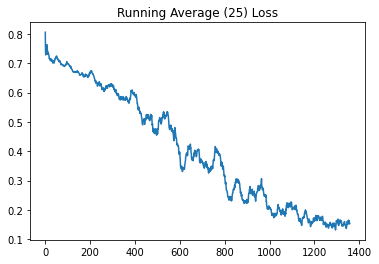




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 6822
	Loading model...
	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.715445
			Batch  100 Loss:	0.689852
			Batch  150 Loss:	0.657636
		Training Results:
		Loss: 0.670872
		Validation Results:
		Loss: 0.667215	F1: 0.6683
			Recall: 0.7733	Precision: 0.5885
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.664590	F1: 0.6607
			Recall: 0.7696	Precision: 0.5787
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.623792
			Batch  100 Loss:	0.596448
			Batch  150 Loss:	0.565048
		Training Results:
		Loss: 0.578867
		Validation Results:
		Loss: 0.583214	F1: 0.7346
			Recall: 0.7965	Precision: 0.6816
New bes

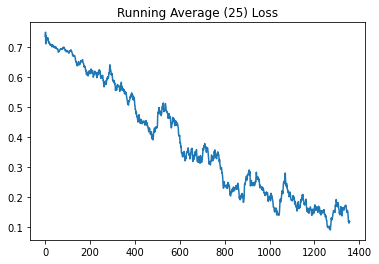




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 2622
	Loading model...
	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.731190
			Batch  100 Loss:	0.674631
			Batch  150 Loss:	0.652009
		Training Results:
		Loss: 0.672048
		Validation Results:
		Loss: 0.648492	F1: 0.6566
			Recall: 0.7558	Precision: 0.5804
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.646017	F1: 0.6620
			Recall: 0.7435	Precision: 0.5966
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.612795
			Batch  100 Loss:	0.595053
			Batch  150 Loss:	0.560945
		Training Results:
		Loss: 0.581303
		Validation Results:
		Loss: 0.609444	F1: 0.6280
			Recall: 0.5349	Precision: 0.7603
	 -----

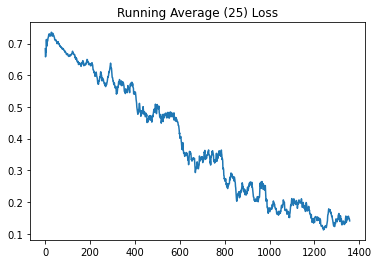




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 680
	Loading model...
	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.735129
			Batch  100 Loss:	0.693674
			Batch  150 Loss:	0.686876
		Training Results:
		Loss: 0.689033
		Validation Results:
		Loss: 0.634915	F1: 0.5552
			Recall: 0.4535	Precision: 0.7156
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.621032	F1: 0.5723
			Recall: 0.4764	Precision: 0.7165
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.614948
			Batch  100 Loss:	0.620640
			Batch  150 Loss:	0.599731
		Training Results:
		Loss: 0.602474
		Validation Results:
		Loss: 0.595438	F1: 0.6625
			Recall: 0.6105	Precision: 0.7241
New bes

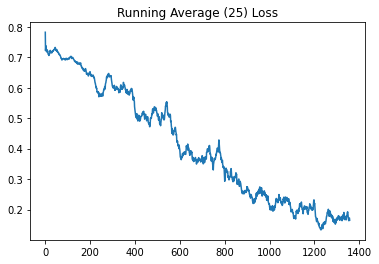




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 5445
	Loading model...
	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.708393
			Batch  100 Loss:	0.682142
			Batch  150 Loss:	0.673146
		Training Results:
		Loss: 0.675310
		Validation Results:
		Loss: 0.652787	F1: 0.6393
			Recall: 0.6802	Precision: 0.6031
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.650540	F1: 0.6667
			Recall: 0.7382	Precision: 0.6078
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.619084
			Batch  100 Loss:	0.631158
			Batch  150 Loss:	0.583540
		Training Results:
		Loss: 0.600981
		Validation Results:
		Loss: 0.638332	F1: 0.7095
			Recall: 0.8023	Precision: 0.6359
New bes

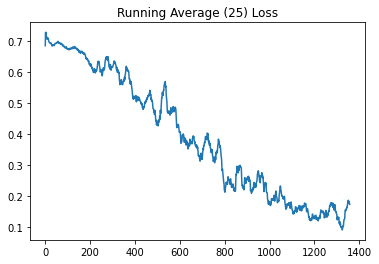




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 1978
	Loading model...
	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.731385
			Batch  100 Loss:	0.685753
			Batch  150 Loss:	0.668370
		Training Results:
		Loss: 0.680141
		Validation Results:
		Loss: 0.615786	F1: 0.7212
			Recall: 0.8198	Precision: 0.6438
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.642666	F1: 0.6667
			Recall: 0.7801	Precision: 0.5820
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.620484
			Batch  100 Loss:	0.601452
			Batch  150 Loss:	0.571155
		Training Results:
		Loss: 0.596838
		Validation Results:
		Loss: 0.572136	F1: 0.7118
			Recall: 0.7035	Precision: 0.7202
	 -----

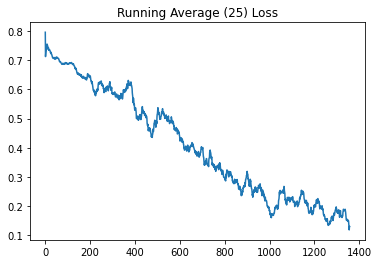




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 7617
	Loading model...
	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.719047
			Batch  100 Loss:	0.689073
			Batch  150 Loss:	0.682257
		Training Results:
		Loss: 0.685517
		Validation Results:
		Loss: 0.637442	F1: 0.6344
			Recall: 0.6105	Precision: 0.6604
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.665807	F1: 0.5785
			Recall: 0.5497	Precision: 0.6105
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.648503
			Batch  100 Loss:	0.604255
			Batch  150 Loss:	0.624721
		Training Results:
		Loss: 0.622521
		Validation Results:
		Loss: 0.585113	F1: 0.6981
			Recall: 0.7326	Precision: 0.6667
New bes

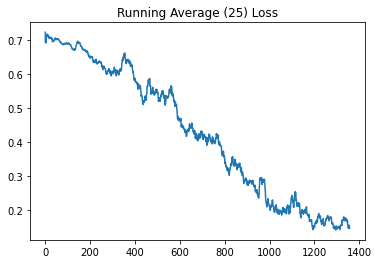




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 7281
	Loading model...
	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.719791
			Batch  100 Loss:	0.673138
			Batch  150 Loss:	0.669754
		Training Results:
		Loss: 0.676774
		Validation Results:
		Loss: 0.649598	F1: 0.6629
			Recall: 0.6744	Precision: 0.6517
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.643158	F1: 0.6286
			Recall: 0.6335	Precision: 0.6237
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.636584
			Batch  100 Loss:	0.609270
			Batch  150 Loss:	0.591936
		Training Results:
		Loss: 0.604232
		Validation Results:
		Loss: 0.614260	F1: 0.7161
			Recall: 0.8140	Precision: 0.6393
New bes

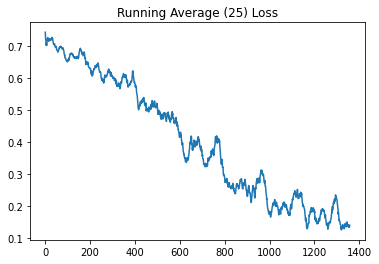




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 1728
	Loading model...
	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.716187
			Batch  100 Loss:	0.675814
			Batch  150 Loss:	0.668844
		Training Results:
		Loss: 0.679017
		Validation Results:
		Loss: 0.632223	F1: 0.6686
			Recall: 0.6570	Precision: 0.6807
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.631227	F1: 0.6467
			Recall: 0.6230	Precision: 0.6723
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.630225
			Batch  100 Loss:	0.602270
			Batch  150 Loss:	0.610154
		Training Results:
		Loss: 0.609658
		Validation Results:
		Loss: 0.570195	F1: 0.6921
			Recall: 0.6337	Precision: 0.7622
New bes

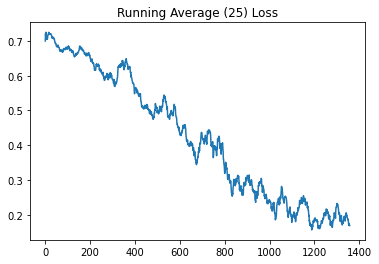




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 1386
	Loading model...
	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.736634
			Batch  100 Loss:	0.686140
			Batch  150 Loss:	0.659219
		Training Results:
		Loss: 0.682333
		Validation Results:
		Loss: 0.637029	F1: 0.6684
			Recall: 0.7558	Precision: 0.5991
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.637879	F1: 0.7119
			Recall: 0.7958	Precision: 0.6441
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.636527
			Batch  100 Loss:	0.609000
			Batch  150 Loss:	0.591682
		Training Results:
		Loss: 0.600057
		Validation Results:
		Loss: 0.561545	F1: 0.6940
			Recall: 0.6395	Precision: 0.7586
New bes

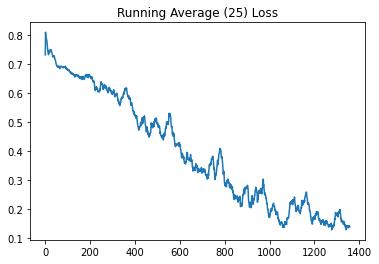




Experiment completed!!


In [ ]:
bioclinbert.run_experiments()

In [ ]:
bluebert = Experiment(num_trials=NUM_TRIALS,
                      data=X,
                      labels=y,
                      model_type='bluebert',
                      frozen=False,
                      epochs=EPOCHS,
                      bsz=BSZ,
                      lr=LR,
                      path='bluebert',
                      seeds=SEEDS
                      )

"bluebert = Experiment(num_trials=NUM_TRIALS,\n                      data=X,\n                      labels=y,\n                      model_type='bluebert',\n                      frozen=False,\n                      epochs=EPOCHS,\n                      bsz=BSZ,\n                      lr=LR,\n                      path='bluebert',\n                      seeds=SEEDS\n                      )"

In [ ]:
bluebert.run_experiments()

In [ ]:
pubmedbert = Experiment(num_trials=NUM_TRIALS,
                      data=X,
                      labels=y,
                      model_type='pubmedbert',
                      frozen=False,
                      epochs=EPOCHS,
                      bsz=BSZ,
                      lr=LR,
                      path='pubmedbert',
                      seeds=SEEDS
                      )

]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 3292
	Loading model...
	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.710828
			Batch  100 Loss:	0.668741
			Batch  150 Loss:	0.641294
		Training Results:
		Loss: 0.664695
		Validation Results:
		Loss: 0.645632	F1: 0.6941
			Recall: 0.9302	Precision: 0.5536
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.644721	F1: 0.6992
			Recall: 0.9372	Precision: 0.5576
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.593213
			Batch  100 Loss:	0.571625
			Batch  150 Loss:	0.565695
		Training Results:
		Loss: 0.569317
		Validation Results:
		Loss: 0.544226	F1: 0.7720
			Recall: 0.8663	Precision: 0.6963
New bes

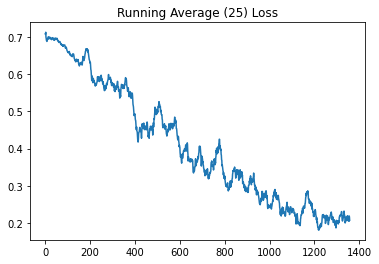




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 6822
	Loading model...
	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.714519
			Batch  100 Loss:	0.660658
			Batch  150 Loss:	0.645969
		Training Results:
		Loss: 0.658015
		Validation Results:
		Loss: 0.610676	F1: 0.6325
			Recall: 0.6105	Precision: 0.6562
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.600220	F1: 0.6630
			Recall: 0.6230	Precision: 0.7083
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.566509
			Batch  100 Loss:	0.565943
			Batch  150 Loss:	0.528521
		Training Results:
		Loss: 0.543233
		Validation Results:
		Loss: 0.534751	F1: 0.7596
			Recall: 0.8081	Precision: 0.7165
New bes

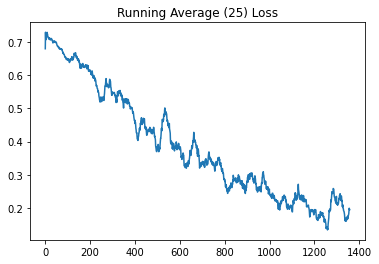




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 2622
	Loading model...
	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.714023
			Batch  100 Loss:	0.670726
			Batch  150 Loss:	0.627111
		Training Results:
		Loss: 0.660962
		Validation Results:
		Loss: 0.638229	F1: 0.6890
			Recall: 0.8372	Precision: 0.5854
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.640406	F1: 0.7095
			Recall: 0.8377	Precision: 0.6154
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.605243
			Batch  100 Loss:	0.573957
			Batch  150 Loss:	0.532662
		Training Results:
		Loss: 0.548923
		Validation Results:
		Loss: 0.551729	F1: 0.7546
			Recall: 0.8314	Precision: 0.6908
New bes

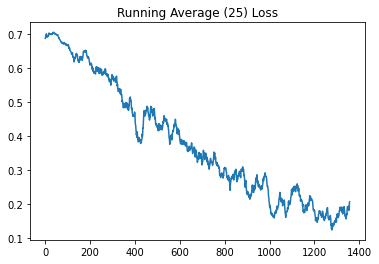




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 680
	Loading model...
	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.729081
			Batch  100 Loss:	0.661407
			Batch  150 Loss:	0.652071
		Training Results:
		Loss: 0.663357
		Validation Results:
		Loss: 0.594011	F1: 0.6770
			Recall: 0.6337	Precision: 0.7267
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.561164	F1: 0.7193
			Recall: 0.6440	Precision: 0.8146
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.596228
			Batch  100 Loss:	0.532157
			Batch  150 Loss:	0.536145
		Training Results:
		Loss: 0.541053
		Validation Results:
		Loss: 0.469632	F1: 0.7923
			Recall: 0.8430	Precision: 0.7474
New bes

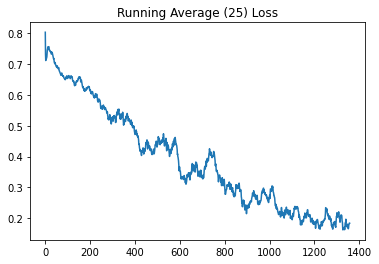




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 5445
	Loading model...
	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.722040
			Batch  100 Loss:	0.660276
			Batch  150 Loss:	0.647320
		Training Results:
		Loss: 0.661047
		Validation Results:
		Loss: 0.586341	F1: 0.6939
			Recall: 0.6919	Precision: 0.6959
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.572510	F1: 0.7164
			Recall: 0.7539	Precision: 0.6825
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.571767
			Batch  100 Loss:	0.549046
			Batch  150 Loss:	0.518202
		Training Results:
		Loss: 0.529802
		Validation Results:
		Loss: 0.480486	F1: 0.7943
			Recall: 0.8081	Precision: 0.7809
New bes

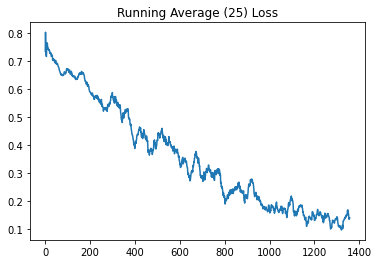




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 1978
	Loading model...
	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.711217
			Batch  100 Loss:	0.680048
			Batch  150 Loss:	0.651568
		Training Results:
		Loss: 0.668245
		Validation Results:
		Loss: 0.617748	F1: 0.6877
			Recall: 0.7616	Precision: 0.6268
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.619210	F1: 0.6890
			Recall: 0.7539	Precision: 0.6344
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.603059
			Batch  100 Loss:	0.564605
			Batch  150 Loss:	0.530026
		Training Results:
		Loss: 0.554431
		Validation Results:
		Loss: 0.517853	F1: 0.7714
			Recall: 0.7849	Precision: 0.7584
New bes

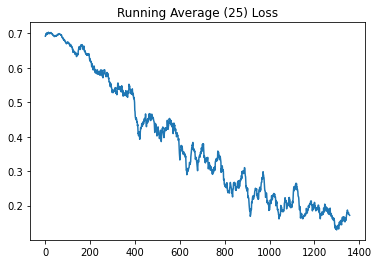




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 7617
	Loading model...
	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.702314
			Batch  100 Loss:	0.676114
			Batch  150 Loss:	0.649620
		Training Results:
		Loss: 0.660675
		Validation Results:
		Loss: 0.556753	F1: 0.7459
			Recall: 0.7849	Precision: 0.7105
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.613527	F1: 0.6736
			Recall: 0.6806	Precision: 0.6667
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.609392
			Batch  100 Loss:	0.537317
			Batch  150 Loss:	0.547770
		Training Results:
		Loss: 0.550416
		Validation Results:
		Loss: 0.496670	F1: 0.7790
			Recall: 0.8198	Precision: 0.7421
New bes

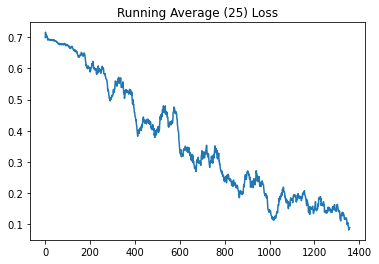




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 7281
	Loading model...
	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.692949
			Batch  100 Loss:	0.675281
			Batch  150 Loss:	0.660016
		Training Results:
		Loss: 0.659625
		Validation Results:
		Loss: 0.626671	F1: 0.6328
			Recall: 0.6163	Precision: 0.6503
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.606583	F1: 0.6803
			Recall: 0.6963	Precision: 0.6650
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.638431
			Batch  100 Loss:	0.587345
			Batch  150 Loss:	0.581947
		Training Results:
		Loss: 0.584440
		Validation Results:
		Loss: 0.519253	F1: 0.7978
			Recall: 0.8488	Precision: 0.7526
New bes

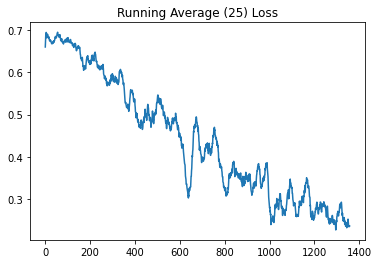




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 1728
	Loading model...
	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.712537
			Batch  100 Loss:	0.663119
			Batch  150 Loss:	0.659079
		Training Results:
		Loss: 0.657374
		Validation Results:
		Loss: 0.590203	F1: 0.7400
			Recall: 0.8605	Precision: 0.6491
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.624393	F1: 0.7101
			Recall: 0.8272	Precision: 0.6220
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.527898
			Batch  100 Loss:	0.535848
			Batch  150 Loss:	0.497191
		Training Results:
		Loss: 0.511363
		Validation Results:
		Loss: 0.471573	F1: 0.7910
			Recall: 0.8140	Precision: 0.7692
New bes

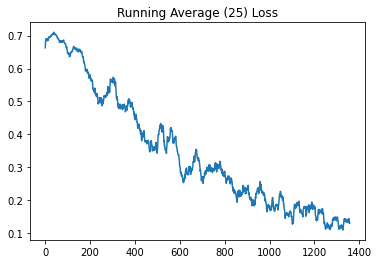




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 1386
	Loading model...
	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.721909
			Batch  100 Loss:	0.663515
			Batch  150 Loss:	0.640518
		Training Results:
		Loss: 0.660994
		Validation Results:
		Loss: 0.599797	F1: 0.7011
			Recall: 0.7500	Precision: 0.6582
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.595692	F1: 0.7111
			Recall: 0.7539	Precision: 0.6729
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.596816
			Batch  100 Loss:	0.569635
			Batch  150 Loss:	0.514943
		Training Results:
		Loss: 0.546112
		Validation Results:
		Loss: 0.649195	F1: 0.7333
			Recall: 0.8953	Precision: 0.6210
New bes

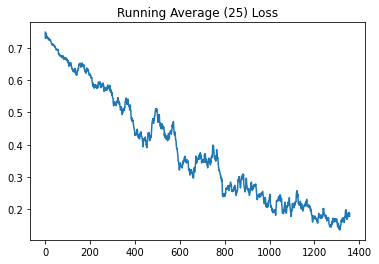




Experiment completed!!


In [ ]:
pubmedbert.run_experiments()

In [ ]:
SAVE = '/content/gdrive/My Drive/work/covid_lbd/filtering/'

bert = PubMedBERT()  # Best performing model
bert.load_state_dict(torch.load(SAVE+'weights/pubmed_bert_best.pth')
bert.eval()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(bert.weight_path)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

bert.to(device)

data = pd.read_csv(SAVE + 'reduced_preds.csv', sep='\t', header=0)

encoding = tokenizer(data, return_tensors='pt', 
                     padding=True, truncation=True, 
                     verbose=False)

input_ids = encoding['input_ids'].to(device)
token_type_ids = encoding['token_type_ids'].to(device)
attn_mask = encoding['attention_mask'].to(device)

In [ ]:
keep = []

for i, row in data.iterrows():
  output = bert(input_ids, token_type_ids, attn_mask)
  clf = torch.argmax(F.softmax(output[1], dim=1), dim=1).cpu().detach().item()
  if clf >= 0.5:
    keep.append(row)

In [ ]:
keep = pd.DataFrame(keep)
keep.to_csv(SAVE+'filtered_preds.csv', sep='|', header=True, index=False)